In [2]:
import sys, os
sys.path.append(os.path.abspath("../../"))

In [3]:
from core_elts import lib as core
from snia_elements import lib as snia
from snia_no_elements import lib as snia_no_elts

In [7]:
core.detailed_enrichment_init()
snia.detailed_enrichment_init()

In [8]:
from collections import defaultdict
import numpy as np
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm import tqdm_notebook as tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [9]:
bpl.presentation_style()

In [10]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.1, 50, total_mass=1)

In [11]:
age_8 = lt.lifetime(8.0, 0.02)

In [12]:
dt = 1E6
times = np.arange(dt, 14E9, dt)

In [13]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe", "Z"]

In [18]:
idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
        "Z": 7, "E": 8, "N_SN_left": 9}
idxs_no_elts = {"Z":0, "E":1, "N_sn_left":2}

In [24]:
class SNIa(object):
    def __init__(self, name, module, idxs):
        self.name = name
        self.module = module
        self.idxs = idxs
    
    def sn_ia_core_py(self, *args):
        return self.module.sn_ia_core_py(*args)
    
    def get_sn_ia_rate_py(self, *args):
        return self.module.get_sn_ia_rate_py(*args)

In [25]:
SN_elts = SNIa("All Elements", snia, idxs)
SN_no_elts = SNIa("Z only", snia_no_elts, idxs_no_elts)

In [15]:
E_0 = 2E51  # default SN energy

# check the SN rates
I'll do this for a huge stellar mass, so we have SN at each timestep and so can more easily compare it to the expected rates

In [16]:
m_test = 1E20

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


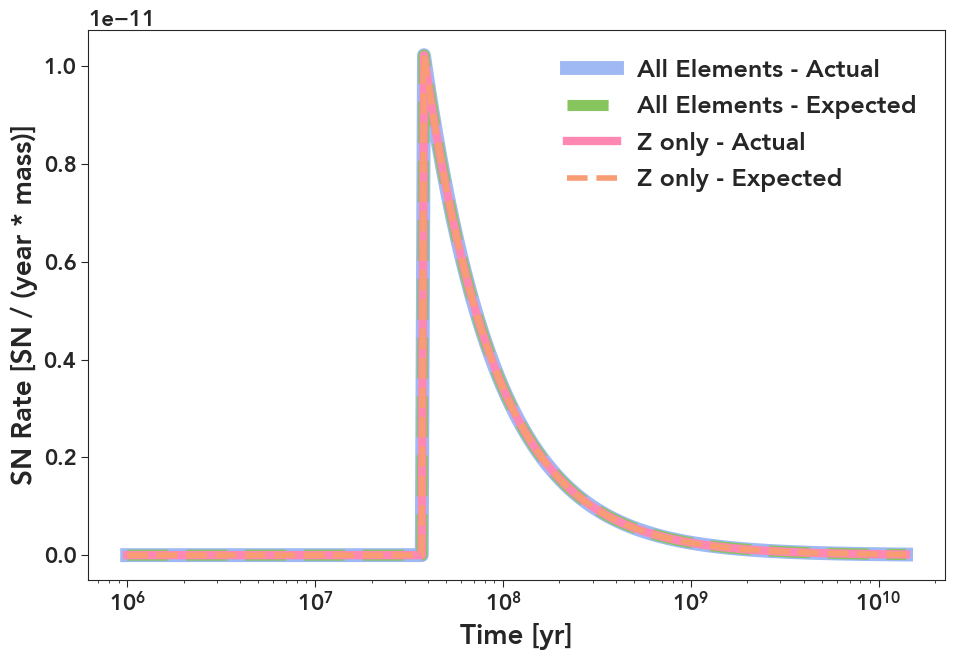

In [30]:
fig, ax = bpl.subplots()
lw = 10
for sn in [SN_elts, SN_no_elts]:
    n_sn = [sn.sn_ia_core_py(0, t, dt, m_test, 0.02, age_8)[sn.idxs["E"]] / E_0
            for t in times]
    sn_rates = [n / (dt * m_test) for n in n_sn] 
    
    expected_rates = [sn.get_sn_ia_rate_py(t, age_8) for t in times]
    
    ax.plot(times, sn_rates, lw=lw, label="{} - Actual".format(sn.name))
    ax.plot(times, expected_rates, lw=lw-2, ls="--", label="{} - Expected".format(sn.name))
    lw -= 4
    
ax.set_xscale("log")
ax.add_labels("Time [yr]", "SN Rate [SN / (year * mass)]")
ax.legend()

# then plot things about the yields

In [38]:
n_sn_elts = [SN_elts.sn_ia_core_py(0, t, dt, m_test, 0.02, age_8)[SN_elts.idxs["E"]] / E_0
        for t in times]

n_sn_no_elts = [SN_no_elts.sn_ia_core_py(0, t, dt, m_test, 0.02, age_8)[SN_no_elts.idxs["E"]] / E_0
        for t in times]

yields = dict()
for elt in elts:
    yields[elt] = [SN_elts.sn_ia_core_py(0, t, dt, m_test, 0.02, age_8)[SN_elts.idxs[elt]]
                   for t in times]

yields["Z_only"] = [SN_no_elts.sn_ia_core_py(0, t, dt, m_test, 0.02, age_8)[SN_no_elts.idxs["Z"]]
                    for t in times]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


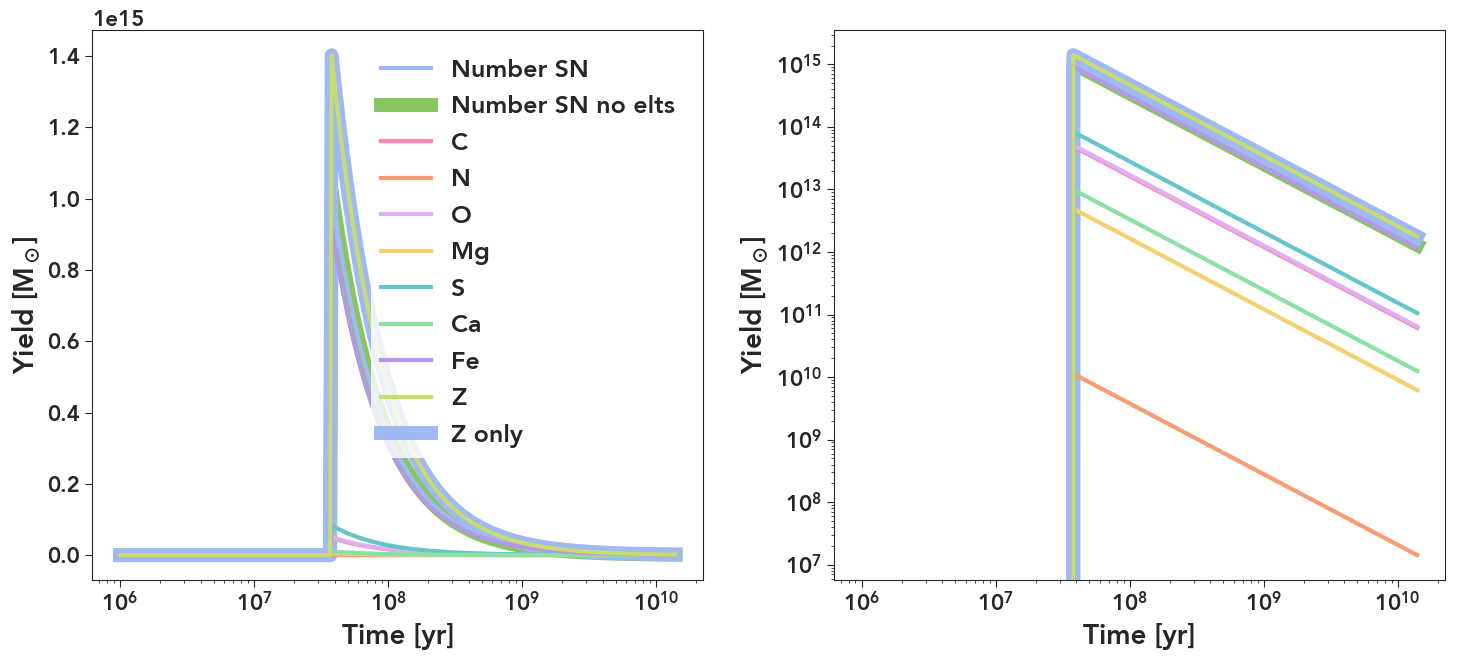

In [41]:
fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])
for ax in axs:
    ax.plot(times, n_sn_elts, label="Number SN")
    ax.plot(times, n_sn_no_elts, lw=10, label="Number SN no elts", zorder=0)
    for elt in elts:
        ax.plot(times, yields[elt], label=elt)
        
    ax.plot(times, yields["Z_only"], lw=10, label="Z only", zorder=0)
    ax.set_xscale("log")
    ax.add_labels("Time [yr]", "Yield [$M_\odot$]")
    
axs[0].legend()
axs[1].set_yscale("log")

# Try with lower mass to show discreteness

Here I won't bother trying to track the leftover SN

In [43]:
n_sn_small = [SN_elts.sn_ia_core_py(0, t, dt, 1E6, 0.02, age_8)[SN_elts.idxs["E"]] / E_0
             for t in times]
yields_small = dict()
for elt in elts:
    yields_small[elt] = [SN_elts.sn_ia_core_py(0, t, dt, 1E6, 0.02, age_8)[SN_elts.idxs[elt]]
                         for t in times]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


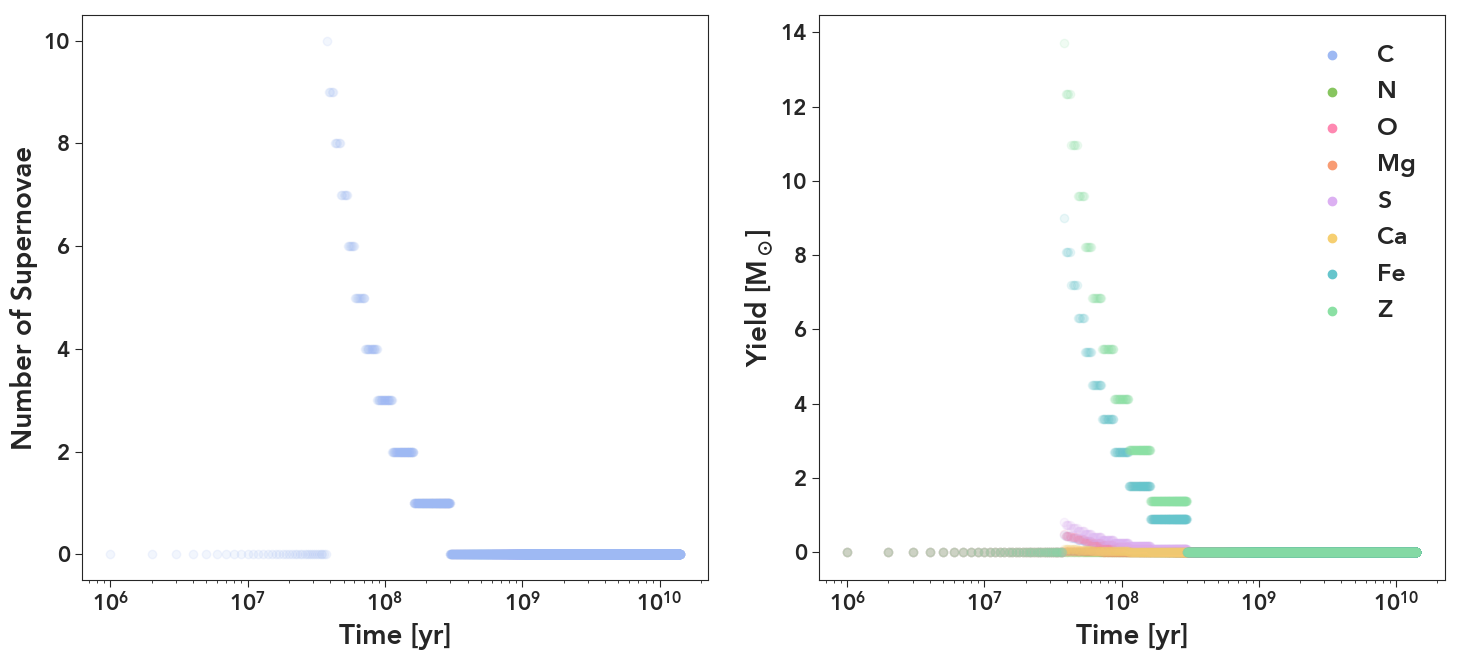

In [44]:
fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])

axs[0].scatter(times, n_sn_small, label="Number SN")

for elt in elts:
    axs[1].scatter(times, yields_small[elt], label=elt)

axs[0].add_labels("Time [yr]", "Number of Supernovae")
axs[1].add_labels("Time [yr]", "Yield [$M_\odot$]")
axs[1].legend()
axs[0].set_xscale("log")
axs[1].set_xscale("log")

In [45]:
n_sn_small_no_elts = [SN_no_elts.sn_ia_core_py(0, t, dt, 1E6, 0.02, age_8)[SN_no_elts.idxs["E"]] / E_0
             for t in times]
yields_small_no_elts = dict()
yields_small_no_elts[elt] = [SN_no_elts.sn_ia_core_py(0, t, dt, 1E6, 0.02, age_8)[SN_no_elts.idxs["Z"]]
                     for t in times]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


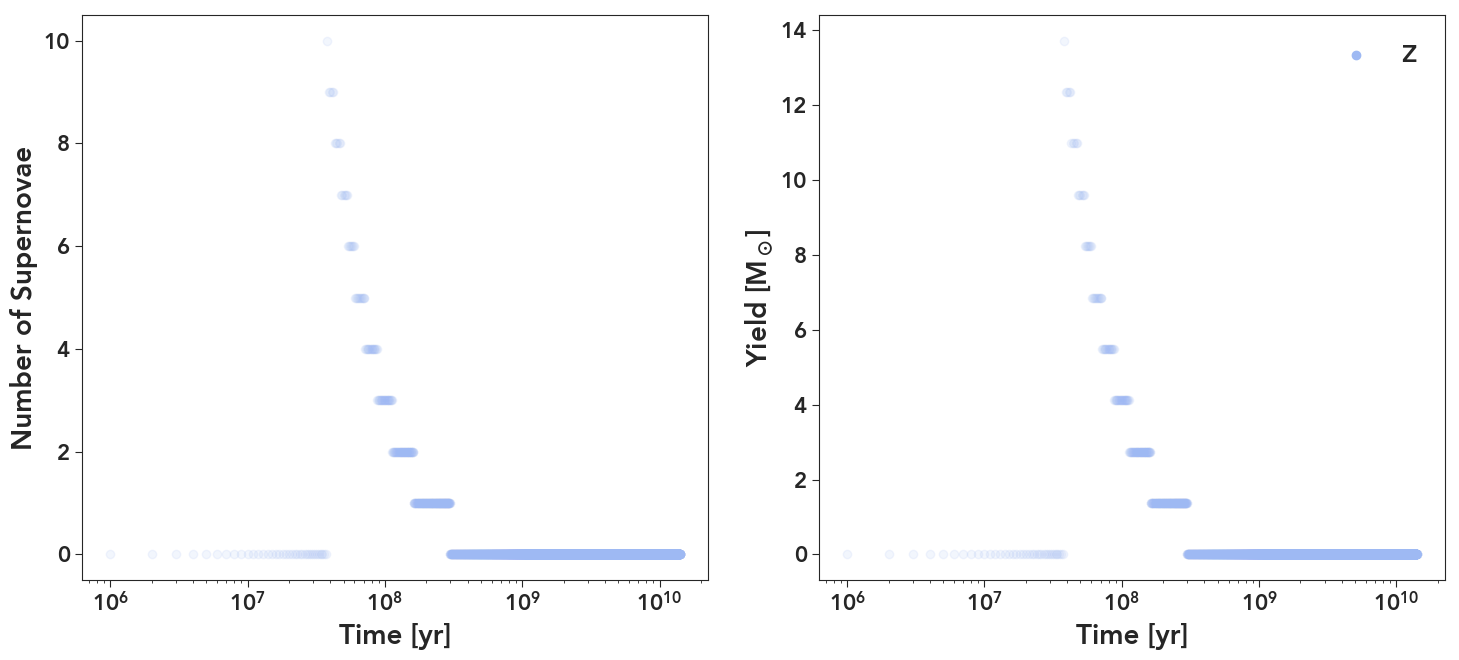

In [47]:
fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])

axs[0].scatter(times, n_sn_small_no_elts, label="Number SN")

axs[1].scatter(times, yields_small_no_elts["Z"], label="Z")

axs[0].add_labels("Time [yr]", "Number of Supernovae")
axs[1].add_labels("Time [yr]", "Yield [$M_\odot$]")
axs[1].legend()
axs[0].set_xscale("log")
axs[1].set_xscale("log")

Looks excellent, combined with the discreteness tests done in the other file.

# Metallicity changes

In [58]:
zs = [0.001, 0.002, 0.008, 0.014, 0.02, 0.03]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


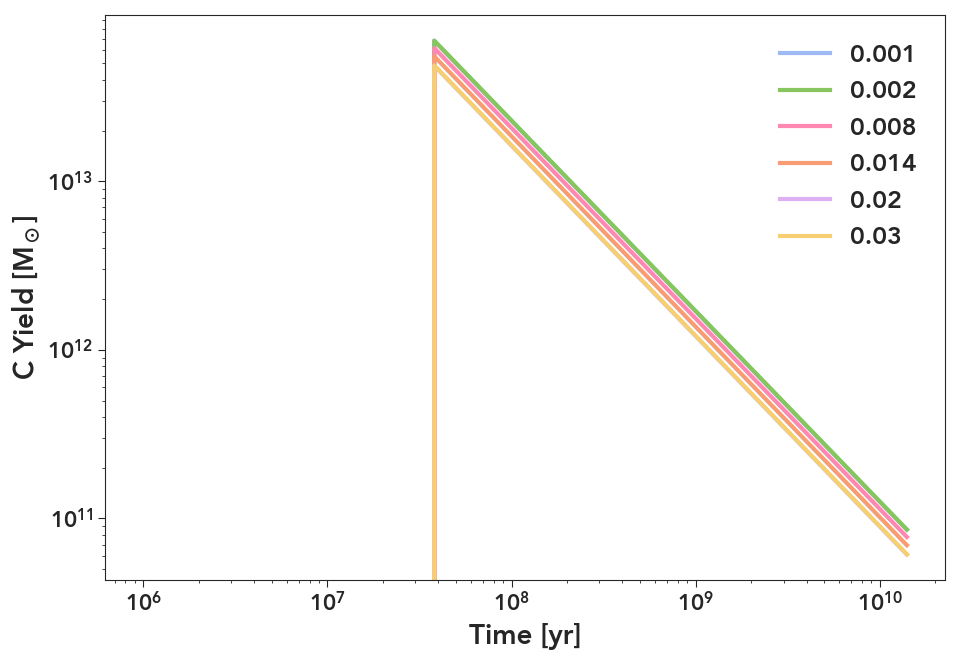

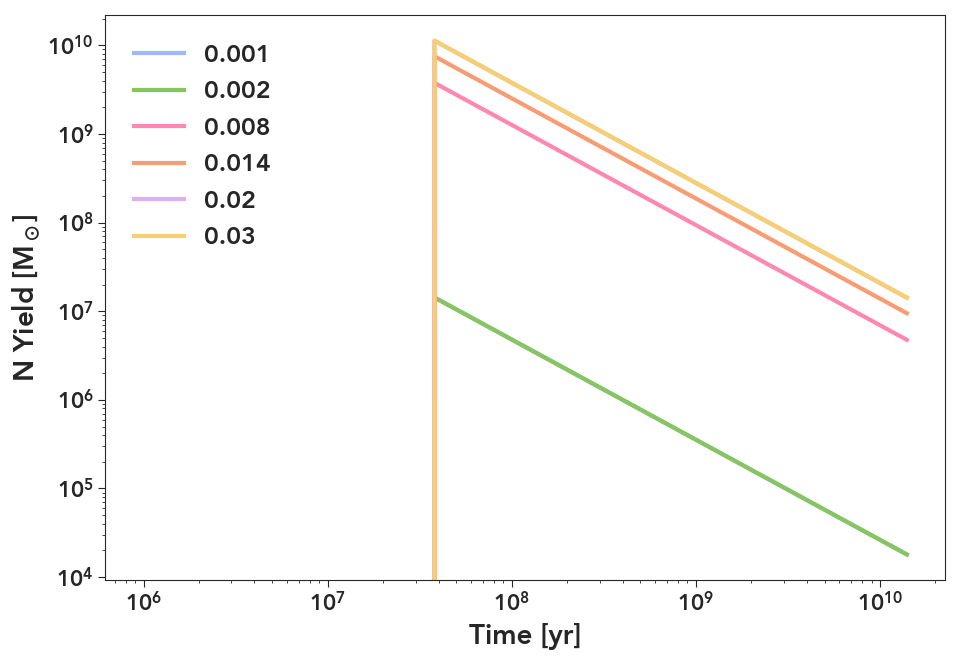

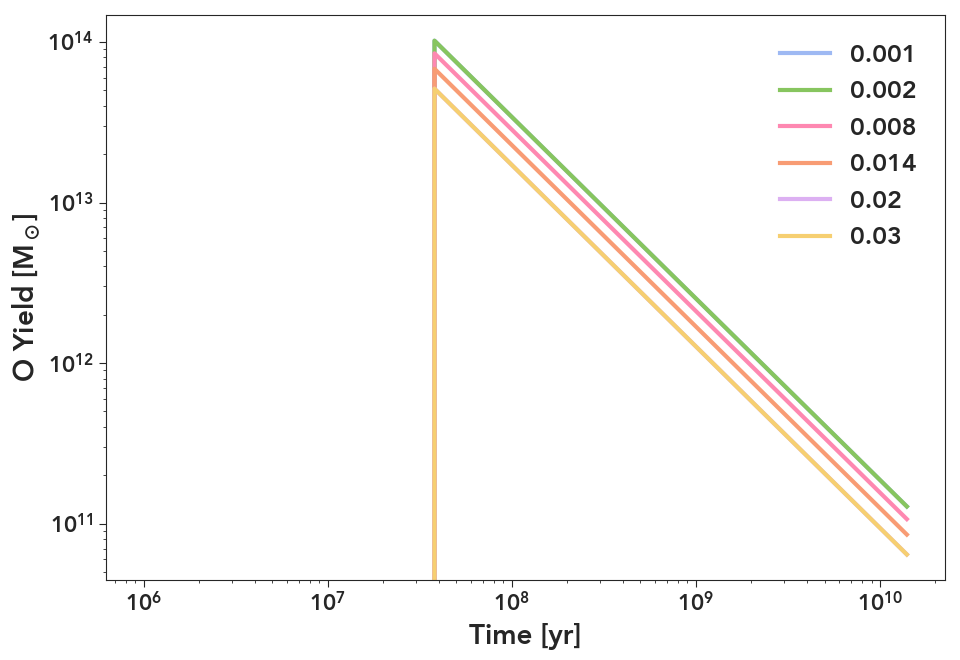

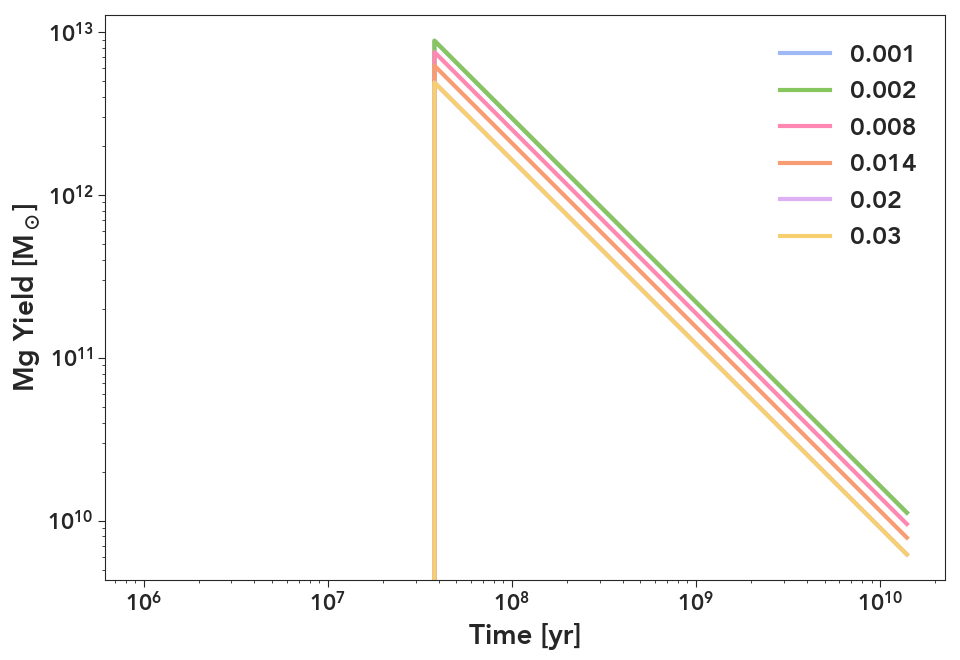

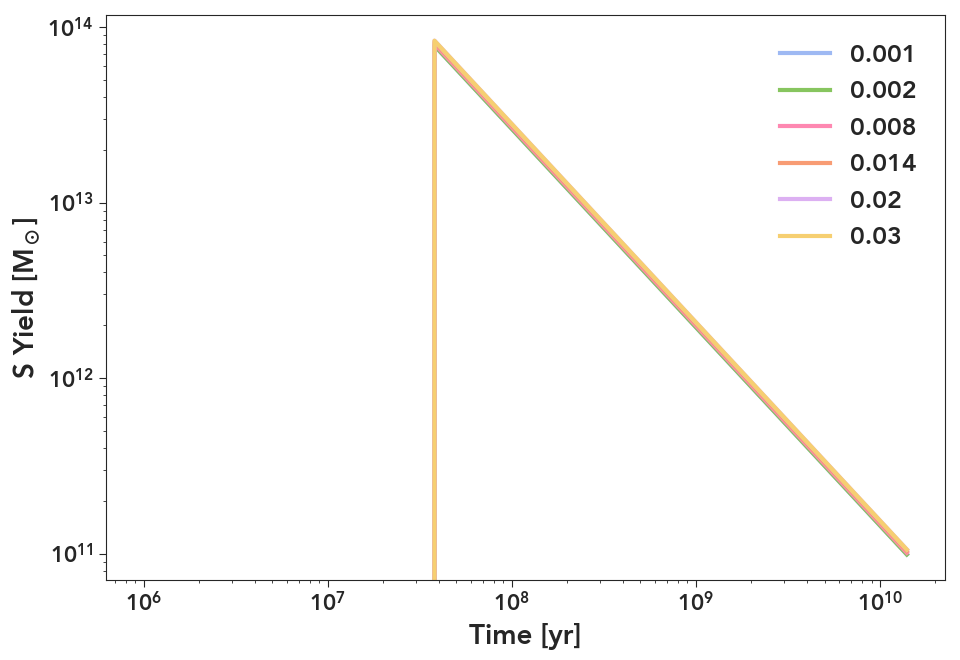

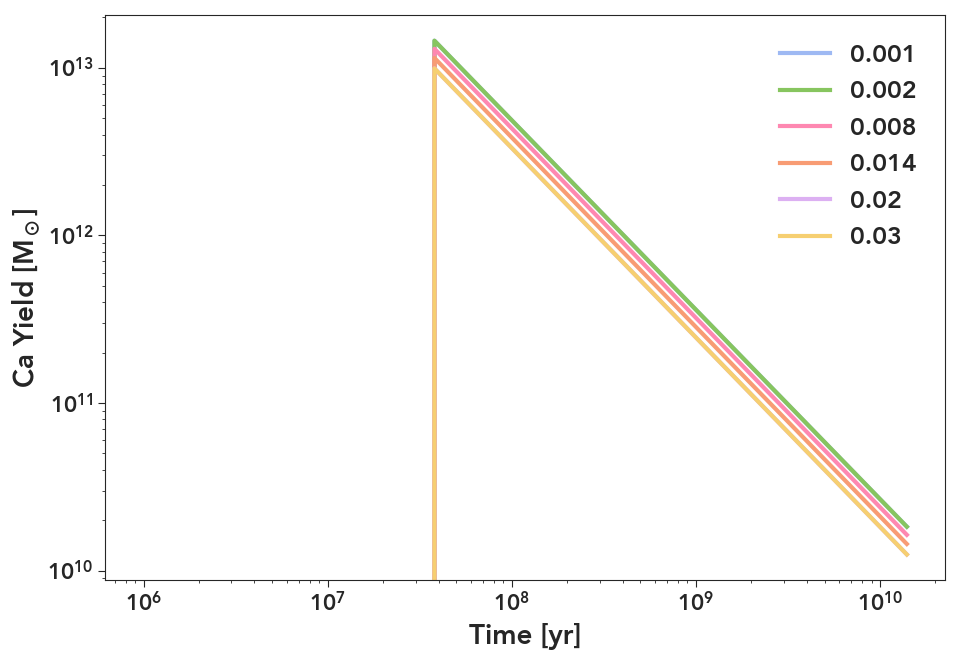

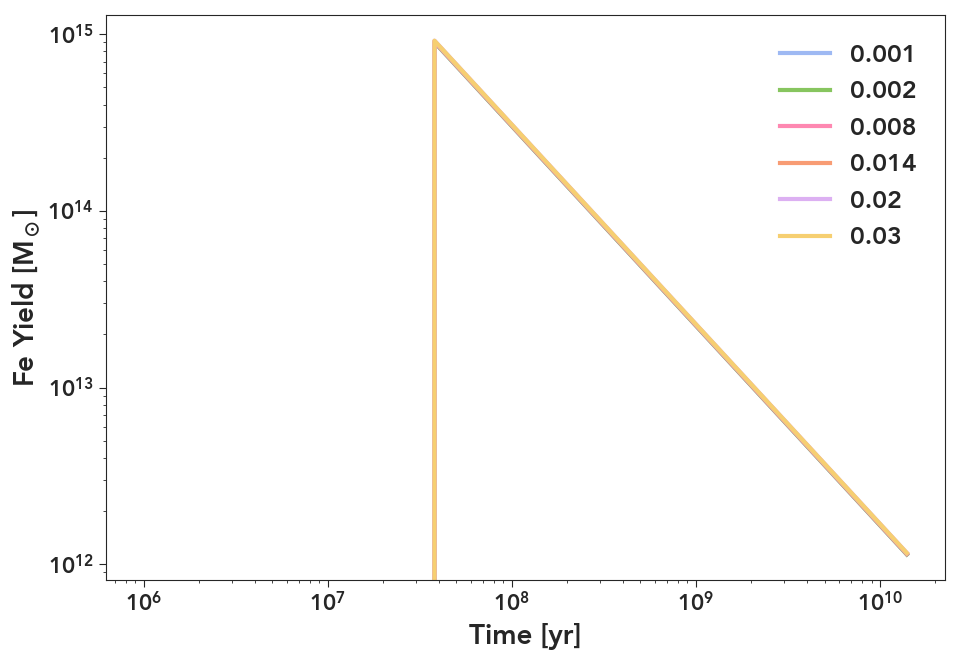

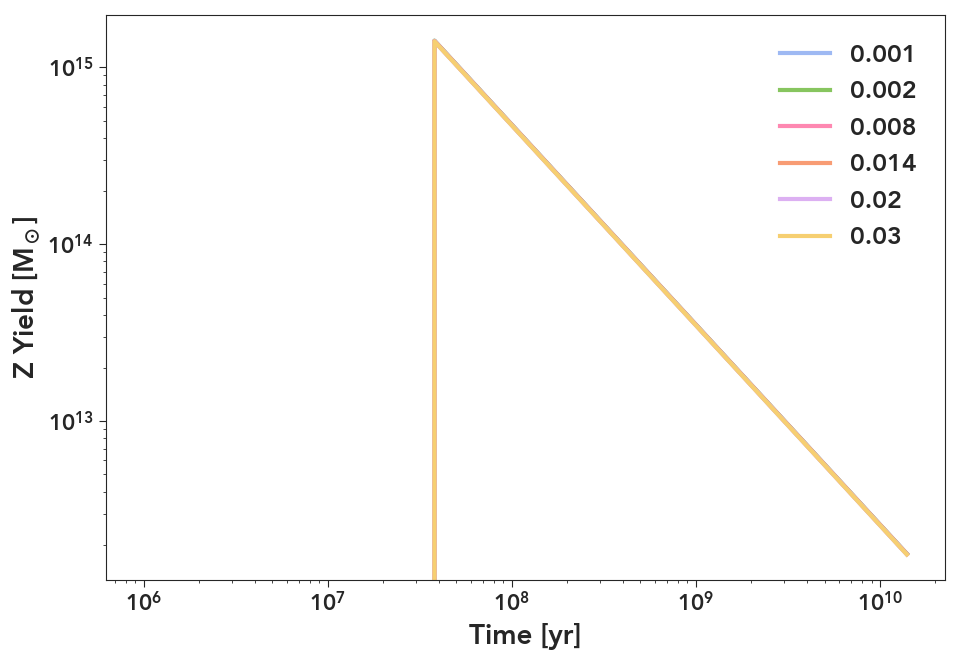

In [59]:
for elt in elts:
    fig, ax = bpl.subplots()
    
    for z in zs:
        y = [SN_elts.sn_ia_core_py(0, t, dt, m_test, z, age_8)[SN_elts.idxs[elt]]
             for t in times]
        ax.plot(times, y, label=z)
    

    ax.add_labels("Time [yr]", "{} Yield [$M_\odot$]".format(elt))
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


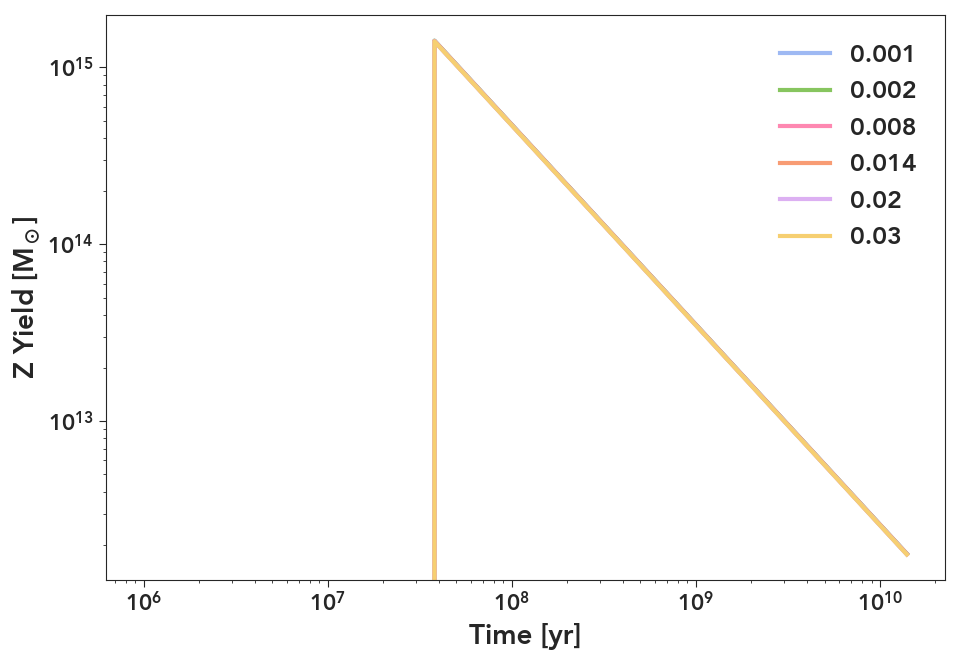

In [61]:

fig, ax = bpl.subplots()

for z in zs:
    y = [SN_elts.sn_ia_core_py(0, t, dt, m_test, z, age_8)[SN_elts.idxs["Z"]]
         for t in times]
    ax.plot(times, y, label=z)


ax.add_labels("Time [yr]", "Z Yield [$M_\odot$]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()